# Download Cora dataset

In [57]:
import torch
import os.path as osp
from torch_geometric.datasets import Planetoid

# Define the path to the dataset directory
path = osp.join('data', 'Cora')

# Load the Cora dataset using the Planetoid class
dataset = Planetoid(path, name='Cora')
data = dataset[0]

# Extract node features, edge index, and labels
node_features = data.x  # (number_of_nodes, number_of_features)
edge_index = data.edge_index  # (2, number_of_edges)
labels = data.y  # (number_of_nodes,)

print(f"Node Features Shape: {node_features.shape}")
print(f"Edge Index Shape: {edge_index.shape}")
print(f"Labels Shape: {labels.shape}")


Node Features Shape: torch.Size([2708, 1433])
Edge Index Shape: torch.Size([2, 10556])
Labels Shape: torch.Size([2708])


Processing...
Done!


# 1. GraphSAGE

## 1.1. Create an Adjacency List and Feature Dictionary

In [58]:
from collections import defaultdict
import numpy as np

# Create adjacency list from edge_index
def build_adj_list(edge_index):
    adj_list = defaultdict(list)
    for i, j in edge_index.t().tolist():
        adj_list[i].append(j)
        adj_list[j].append(i)  # Since it's an undirected graph
    return adj_list

adj_list = build_adj_list(edge_index)

# Convert node features to a dictionary
node_features_dict = {i: node_features[i].numpy() for i in range(node_features.shape[0])}

# Check adjacency list and node features
print("Adjacency List Example (Node 0):", adj_list[0])
print("Node Features Example (Node 0):", node_features_dict[0])


Adjacency List Example (Node 0): [633, 1862, 2582, 633, 1862, 2582]
Node Features Example (Node 0): [0. 0. 0. ... 0. 0. 0.]


## 1.2. Random Sampling of Neighbors

In [78]:
import random

def sample_neighbors(adj_list, node, sample_size):
    """Sample neighbors of a node randomly."""
    neighbors = adj_list.get(node, [])  # Get neighbors or empty list if node has no neighbors
    if len(neighbors) == 0:
        return []  # No neighbors, return empty list
    elif len(neighbors) <= sample_size:
        return neighbors  # Return all neighbors if fewer than sample size
    else:
        return random.sample(neighbors, sample_size)  # Randomly sample neighbors without replacement

# Example: Sample neighbors for node 0
sampled_neighbors = sample_neighbors(adj_list, 0, sample_size=5)
print("Sampled Neighbors for Node 0:", sampled_neighbors)


Sampled Neighbors for Node 0: [633, 2582, 1862, 1862, 2582]


## 1.3. Feature Aggregation

In [61]:
def aggregate_features(node, sampled_neighbors, node_features_dict):
    if len(sampled_neighbors) == 0:
        return np.zeros_like(node_features_dict[node])
    neighbor_features = np.array([node_features_dict[neighbor] for neighbor in sampled_neighbors])
    aggregated_features = np.mean(neighbor_features, axis=0)
    return aggregated_features

# Example: Aggregate features for node 0
aggregated_features_0 = aggregate_features(0, sampled_neighbors, node_features_dict)
print("Aggregated Features for Node 0:", aggregated_features_0)


Aggregated Features for Node 0: [0.  0.  0.  ... 0.  0.4 0. ]


## 1.4. Update Node Representation

In [63]:
def update_node_representation(node, aggregated_features, node_features_dict, weight_matrix):
    # Get the node's feature vector
    node_feature = node_features_dict[node]
    
    # Concatenate the node's feature and the aggregated neighbor features
    concatenated_features = np.concatenate([node_feature, aggregated_features])  # Shape: (2 * input_dim,)
    
    # Perform matrix multiplication: weight_matrix * concatenated_features
    updated_representation = np.dot(weight_matrix, concatenated_features)  # weight_matrix shape: (input_dim, 2 * input_dim)
    
    return updated_representation

# Example: Initialize a weight matrix and update node representation for node 0
input_dim = node_features.shape[1]  # Cora feature dimension is 1433
weight_matrix = np.random.rand(input_dim, 2 * input_dim)  # Shape: (input_dim, 2 * input_dim)

# Assuming we already aggregated features for node 0 using the previous steps
updated_representation_0 = update_node_representation(0, aggregated_features_0, node_features_dict, weight_matrix)
print("Updated Representation for Node 0:", updated_representation_0)


Updated Representation for Node 0: [12.84879872 11.98199988 16.33841434 ... 13.20789477 13.29756926
 12.96612198]


## 1.5. GraphSAGE Layer

In [64]:
def graphsage_layer(adj_list, node_features_dict, sample_size, weight_matrix):
    new_node_features_dict = {}
    for node in node_features_dict:
        sampled_neighbors = sample_neighbors(adj_list, node, sample_size)
        aggregated_features = aggregate_features(node, sampled_neighbors, node_features_dict)
        updated_representation = update_node_representation(node, aggregated_features, node_features_dict, weight_matrix)
        new_node_features_dict[node] = updated_representation
    return new_node_features_dict

# Example: Apply one layer of GraphSAGE
new_node_features_dict = graphsage_layer(adj_list, node_features_dict, sample_size=5, weight_matrix=weight_matrix)
print("New Node Representation for Node 0:", new_node_features_dict[0])


New Node Representation for Node 0: [12.8718061  12.05909992 15.97781065 ... 13.00685744 12.93621315
 13.04651281]


## 1.6. Two-Layer GraphSAGE

In [134]:
def multilayer_graphsage(adj_list, node_features_dict, num_layers, sample_size):
    """Apply multiple layers of GraphSAGE."""
    input_dim = len(next(iter(node_features_dict.values())))  # Get the feature dimension from any node
    current_node_features_dict = node_features_dict
    
    for layer in range(num_layers):
        # Correct weight matrix shape: (input_dim, 2 * input_dim)
        weight_matrix = np.random.rand(input_dim, 2 * input_dim)
        
        # Apply one GraphSAGE layer
        current_node_features_dict = graphsage_layer(adj_list, current_node_features_dict, sample_size, weight_matrix)
    
    return current_node_features_dict

# Example: Apply 2 layers of GraphSAGE
final_node_features_dict = multilayer_graphsage(adj_list, node_features_dict, num_layers=2, sample_size=5)

# Print the final representation of node 0 after 2 layers
print("Final Node Representation for Node 0 after 2 layers:", final_node_features_dict[0])

Final Node Representation for Node 0 after 2 layers: [21631.70786459 21468.99100714 21466.0180551  ... 21681.56553095
 21624.08003047 21730.56945829]


## 1.7 Regression task 

In [138]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

# Extract node features and labels based on the correct node IDs
node_ids = list(final_node_features_dict.keys())  # Get the list of node IDs from the final_node_features dict
X = np.array([final_node_features_dict[node] for node in node_ids])  # Extract the corresponding node features
y = np.array([labels[node] for node in node_ids])  # Extract the corresponding labels for these nodes

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression classifier
clf = LogisticRegression(solver='liblinear',max_iter=1000)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 84.32%


## 1.8 t-SNE víualization

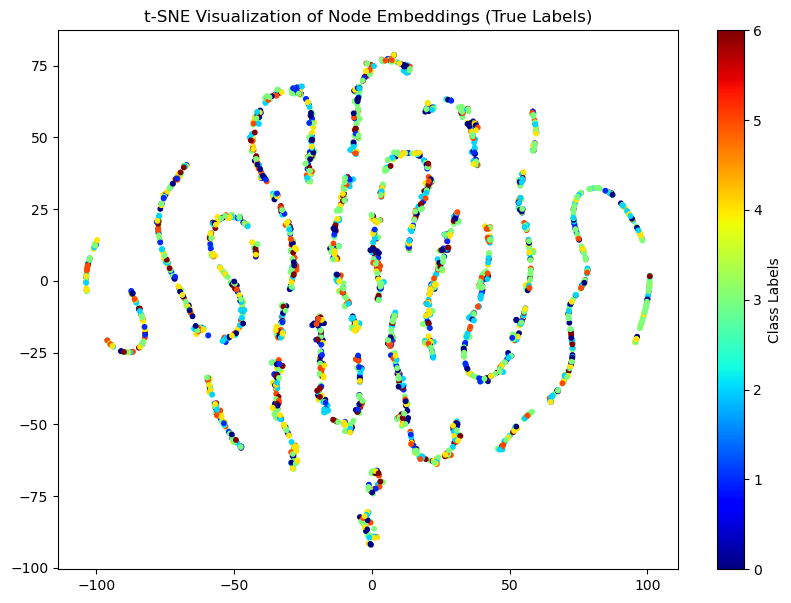

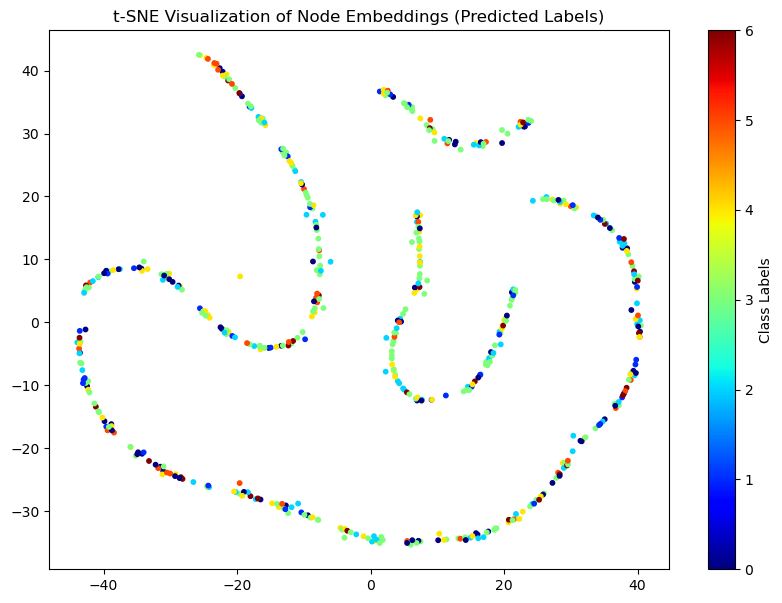

In [139]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensions of node embeddings using t-SNE
def visualize_tsne(X, y, title, perplexity=10):
    """Visualize embeddings using t-SNE."""
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(perplexity, X.shape[0] - 1))
    X_tsne = tsne.fit_transform(X)

    # Plot t-SNE results
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='jet', s=10)
    plt.colorbar(scatter, label='Class Labels')
    plt.title(title)
    plt.show()

# Visualize node embeddings with true labels
visualize_tsne(X, y, "t-SNE Visualization of Node Embeddings (True Labels)")

# Visualize node embeddings with predicted labels
visualize_tsne(X_test, y_pred, "t-SNE Visualization of Node Embeddings (Predicted Labels)")


# 2. GraphSAINT

In [91]:
import torch
import os.path as osp
from torch_geometric.datasets import Planetoid
import numpy as np
from torch_geometric.utils import to_dense_adj

# Define the path to the dataset directory
path = osp.join('data', 'Cora')

# Load the Cora dataset using the Planetoid class
dataset = Planetoid(path, name='Cora')
data = dataset[0]

# Extract node features, edge index, and labels
node_features = data.x.numpy()  # (number_of_nodes, number_of_features)
edge_index = data.edge_index  # (2, numMber_of_edges)
labels = data.y.numpy()  # (number_of_nodes,)

# Convert edge index to dense adjacency matrix
adj_matrix = to_dense_adj(edge_index).squeeze(0)  # (number_of_nodes, number_of_nodes)

print(f"Node Features Shape: {node_features.shape}")
print(f"Edge Index Shape: {edge_index.shape}")
print(f"Labels Shape: {labels.shape}")


Node Features Shape: (2708, 1433)
Edge Index Shape: torch.Size([2, 10556])
Labels Shape: (2708,)


## 2.1. GraphSAINT Sampler

In [82]:
class GraphSAINTSampler:
    def __init__(self, adj, batch_size):
        self.adj = adj  # Adjacency matrix
        self.batch_size = batch_size
        self.N = adj.shape[0]  # Number of nodes
        self.E = adj.shape[1]  # Number of edges
    
    def sample(self, method='node'):
        if method == 'node':
            return self._sample_nodes(self.batch_size)
        elif method == 'edge':
            return self._sample_edges(self.batch_size)
        elif method == 'random_walk':
            return self._sample_random_walk(self.batch_size)

    def _sample_nodes(self, batch_size):
        raise NotImplementedError
    
    def _sample_edges(self, batch_size):
        raise NotImplementedError
    
    def _sample_random_walk(self, batch_size):
        raise NotImplementedError


## 2.2. GraphSAINT Node Sampler

In [83]:
class GraphSAINTNodeSampler(GraphSAINTSampler):
    def _sample_nodes(self, batch_size):
        node_sample = torch.randint(0, self.N, (batch_size,), dtype=torch.long)
        return node_sample


## 2.3. GraphSAINT Edge Sampler

In [84]:
class GraphSAINTEdgeSampler(GraphSAINTSampler):
    def _sample_edges(self, batch_size):
        row, col = self.adj[0], self.adj[1]  # Get edge indices

        deg_in = 1. / np.bincount(col)
        deg_out = 1. / np.bincount(row)

        prob = (1. / deg_in[row]) + (1. / deg_out[col])

        rand = torch.rand(batch_size, self.E).log() / (torch.from_numpy(prob) + 1e-10)
        edge_sample = rand.topk(self.batch_size, dim=-1).indices

        source_node_sample = torch.from_numpy(col[edge_sample])
        target_node_sample = torch.from_numpy(row[edge_sample])

        return torch.cat([source_node_sample, target_node_sample], -1)


## 2.4. GraphSAINT Random Walk Sampler

In [85]:
class GraphSAINTRandomWalkSampler(GraphSAINTSampler):
    def __init__(self, adj, batch_size, walk_length):
        super().__init__(adj, batch_size)
        self.walk_length = walk_length

    def _sample_random_walk(self, batch_size):
        start = torch.randint(0, self.N, (batch_size,), dtype=torch.long)
        walks = [self._random_walk(start_node) for start_node in start]
        walks = torch.cat(walks)
        return walks

    def _random_walk(self, start_node):
        walk = [start_node.item()]
        current = start_node.item()

        for _ in range(self.walk_length):
            neighbors = np.nonzero(self.adj[current])[0]
            if len(neighbors) == 0:
                break
            current = np.random.choice(neighbors)
            walk.append(current)

        return torch.tensor(walk)


## 2.5. 2-layer GraphSAINT GCN

In [92]:
# Define the GraphConvolution layer
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, X, A):
        out = torch.matmul(A, X)
        out = self.fc(out)
        return torch.relu(out)

# Define the GraphSAINT model
class GraphSAINTModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAINTModel, self).__init__()
        self.gc1 = GraphConvolution(input_dim, hidden_dim)
        self.gc2 = GraphConvolution(hidden_dim, output_dim)
    
    def forward(self, X, A):
        h = self.gc1(X, A)
        h = self.gc2(h, A)
        return h

## 2.6. Train the model with mini-batch

In [98]:
def train_model(X, A, labels, model, sampler, epochs=100, batch_size=256, method='node'):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        
        # Mini-batch sampling using the provided sampler method ('node', 'edge', or 'random_walk')
        sampled_nodes = sampler.sample(method=method)
        
        # Create the subgraph from the sampled nodes
        subgraph_A = A[sampled_nodes][:, sampled_nodes]  # Adjacency matrix for subgraph
        subgraph_X = X[sampled_nodes]  # Node features for subgraph
        subgraph_labels = labels[sampled_nodes]  # Labels for subgraph
        
        optimizer.zero_grad()

        # Forward pass
        output = model(subgraph_X, subgraph_A)
        loss = loss_fn(output, subgraph_labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")


## 2.7. Choose parameters

In [104]:
# Create the model and sampler
model = GraphSAINTModel(input_dim=node_features.shape[1], hidden_dim=64, output_dim=7)
sampler = GraphSAINTNodeSampler(data.edge_index, batch_size=64)

# Convert data to tensors
X_tensor = torch.FloatTensor(node_features)
A_tensor = torch.FloatTensor(adj_matrix)
labels_tensor = torch.LongTensor(labels)

# Train the model
train_model(X_tensor, A_tensor, labels_tensor, model, sampler)


Epoch 0, Loss: 1.9267784357070923
Epoch 10, Loss: 1.8433057069778442
Epoch 20, Loss: 1.7713388204574585
Epoch 30, Loss: 1.707328200340271
Epoch 40, Loss: 1.650369644165039
Epoch 50, Loss: 1.5925058126449585
Epoch 60, Loss: 1.5364837646484375
Epoch 70, Loss: 1.4872864484786987
Epoch 80, Loss: 1.4313369989395142
Epoch 90, Loss: 1.393465518951416


## 2.8. t-SNE visualization

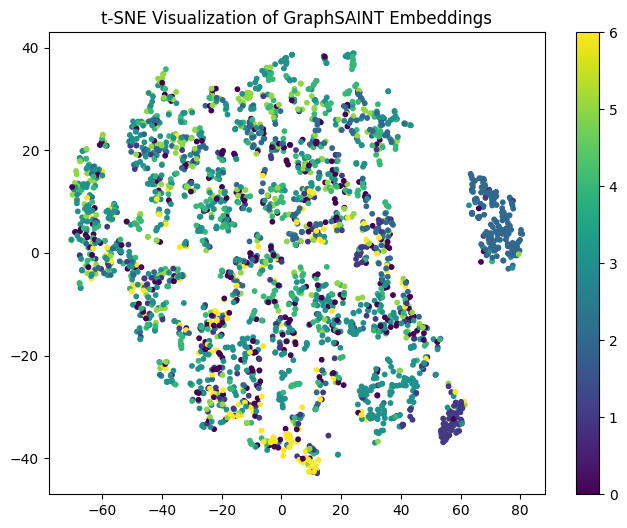

In [100]:
# Visualization function
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(model, X, A, labels):
    model.eval()
    with torch.no_grad():
        embeddings = model(X, A).numpy()

    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', s=10)
    plt.colorbar()
    plt.title("t-SNE Visualization of GraphSAINT Embeddings")
    plt.show()

visualize_embeddings(model, X_tensor, A_tensor, labels)

# 3. ClusterGCN

In [22]:
import torch
import os.path as osp
from torch_geometric.datasets import Planetoid

# Define the path to the dataset directory
path = osp.join('data', 'Cora')

# Load the Cora dataset using the Planetoid class
dataset = Planetoid(path, name='Cora')
data = dataset[0]

# Extract node features, edge index, and labels
node_features = data.x  # (number_of_nodes, number_of_features)
edge_index = data.edge_index  # (2, number_of_edges)
labels = data.y  # (number_of_nodes,)

print(f"Node Features Shape: {node_features.shape}")
print(f"Edge Index Shape: {edge_index.shape}")
print(f"Labels Shape: {labels.shape}")


Node Features Shape: torch.Size([2708, 1433])
Edge Index Shape: torch.Size([2, 10556])
Labels Shape: torch.Size([2708])


## 3.1. Build clusters and batch the data with KMeans

In [35]:
import numpy as np
import torch
from scipy.sparse import csgraph
from sklearn.cluster import KMeans
from sklearn.manifold import SpectralEmbedding
from scipy.sparse.csgraph import connected_components

def build_clusters(edge_index, node_features, num_clusters):
    num_nodes = node_features.shape[0]

    # Step 1: Create adjacency matrix from edge_index
    adj_matrix = np.zeros((num_nodes, num_nodes))
    for edge in edge_index.T:
        adj_matrix[edge[0], edge[1]] = 1
        adj_matrix[edge[1], edge[0]] = 1  # Since it's undirected

    # Step 2: Check connected components
    num_components, labels = connected_components(csgraph=adj_matrix, directed=False, return_labels=True)

    # Initialize clusters
    clusters = []

    # Apply spectral clustering within each connected component
    for component in range(num_components):
        component_nodes = np.where(labels == component)[0]
        if len(component_nodes) < num_clusters:
            # If the component is too small, treat it as one cluster
            clusters.append(component_nodes)
        else:
            # Apply spectral clustering to this component
            sub_adj_matrix = adj_matrix[component_nodes][:, component_nodes]
            spectral_emb = SpectralEmbedding(n_components=num_clusters, affinity='precomputed')
            node_embeddings = spectral_emb.fit_transform(sub_adj_matrix)
            kmeans = KMeans(n_clusters=num_clusters)
            cluster_assignments = kmeans.fit_predict(node_embeddings)

            # Assign nodes to clusters
            for i in range(num_clusters):
                clusters.append(component_nodes[np.where(cluster_assignments == i)[0]])

    return clusters


## 3.2. Define function to extract subgraph for a specific cluster

In [36]:
def extract_subgraph(edge_index, cluster):
    mask = np.isin(edge_index[0].cpu().numpy(), cluster) & np.isin(edge_index[1].cpu().numpy(), cluster)
    sub_edge_index = edge_index[:, mask]
    node_map = {node: i for i, node in enumerate(cluster)}
    sub_edge_index = torch.tensor([[node_map[n.item()] for n in sub_edge_index[0]],
                                   [node_map[n.item()] for n in sub_edge_index[1]]], dtype=torch.long)
    return sub_edge_index

## 3.3. Batch construction with clusters

In [37]:
def construct_batch(clusters, edge_index, node_features, labels):
    batch_node_features = []
    batch_edge_index = []
    batch_labels = []
    for cluster in clusters:
        subgraph_edges = extract_subgraph(edge_index, cluster)
        subgraph_features = node_features[cluster]
        subgraph_labels = labels[cluster]
        batch_node_features.append(subgraph_features)
        batch_edge_index.append(subgraph_edges)
        batch_labels.append(subgraph_labels)
    return batch_node_features, batch_edge_index, batch_labels

## 3.4. Define ClusterGCNLayer

In [38]:
class ClusterGCNLayer(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(ClusterGCNLayer, self).__init__()
        self.linear = torch.nn.Linear(in_features, out_features)

    def forward(self, node_features, edge_index):
        row, col = edge_index
        aggregate = torch.zeros_like(node_features)
        
        for i in range(len(row)):
            aggregate[row[i]] += node_features[col[i]]
        
        return self.linear(aggregate)

## 3.5. Define ClusterGCN model

In [39]:
class ClusterGCN(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(ClusterGCN, self).__init__()
        self.layer1 = ClusterGCNLayer(in_features, hidden_features)
        self.layer2 = ClusterGCNLayer(hidden_features, out_features)

    def forward(self, batch_node_features, batch_edge_index):
        # Process each cluster
        out = []
        for node_features, edge_index in zip(batch_node_features, batch_edge_index):
            x = self.layer1(node_features, edge_index)
            x = torch.relu(x)
            x = self.layer2(x, edge_index)
            out.append(x)
        
        return out

## 3.6. Train ClusterGCN

In [40]:
import torch.optim as optim
import torch.nn as nn

# Define number of clusters
num_clusters = 10
clusters = build_clusters(edge_index, node_features, num_clusters)
batch_node_features, batch_edge_index, batch_labels = construct_batch(clusters, edge_index, node_features, labels)

# Step 2: Train the ClusterGCN model
def train_cluster_gcn(batch_node_features, batch_edge_index, batch_labels):
    all_labels = torch.cat(batch_labels, dim=0)
    model = ClusterGCN(batch_node_features[0].shape[1], 16, len(torch.unique(all_labels)))
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        outputs = model(batch_node_features, batch_edge_index)
        all_outputs = torch.cat(outputs, dim=0)
        loss = loss_fn(all_outputs, all_labels)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

    return model

# Train the model
model = train_cluster_gcn(batch_node_features, batch_edge_index, batch_labels)

Epoch 10, Loss: 0.9902308583259583
Epoch 20, Loss: 0.7295440435409546
Epoch 30, Loss: 0.5450701117515564
Epoch 40, Loss: 0.4241383969783783
Epoch 50, Loss: 0.3398092985153198


## 3.7. Extract node embedding after training

In [41]:
def get_node_embeddings(model, batch_node_features, batch_edge_index):
    model.eval()
    embeddings = []
    with torch.no_grad():
        outputs = model(batch_node_features, batch_edge_index)
        embeddings = torch.cat(outputs, dim=0)
    return embeddings

# Get the trained node embeddings
node_embeddings = get_node_embeddings(model, batch_node_features, batch_edge_index)

# Ensure embeddings are on CPU for t-SNE
node_embeddings = node_embeddings.cpu()


## 3.8. Visualization

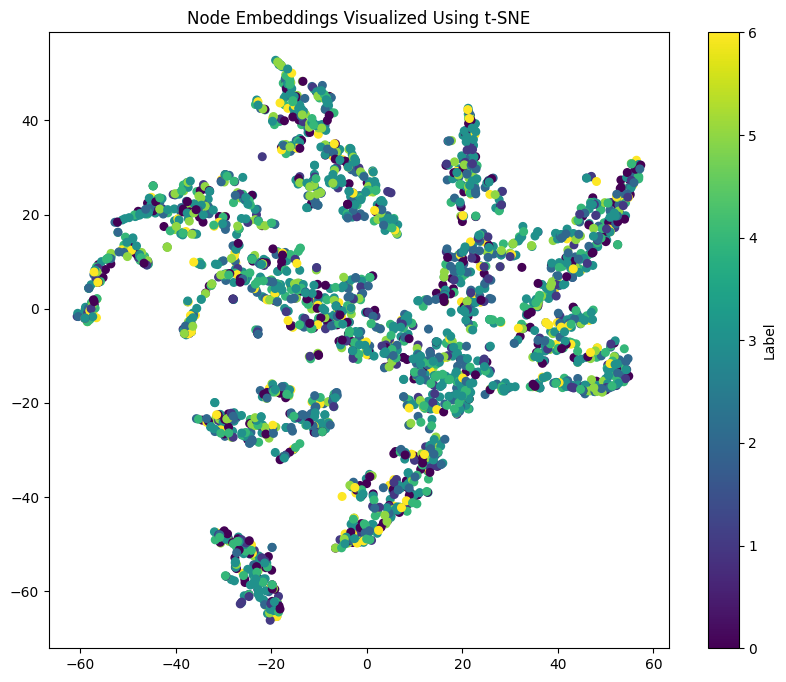

In [46]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

# Step 5: Plot the embeddings, coloring them by their true labels
plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=labels.numpy(), cmap='viridis', s=30)
plt.colorbar(label="Label")
plt.title('Node Embeddings Visualized Using t-SNE')
plt.show()